In [3]:
!pip install sktime
!pip install optuna

import numpy as np
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import optuna.visualization as vis
import warnings


# 한글폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Configure matplotlib for Korean font
plt.rcParams['font.family'] = 'NanumGothic' # Use a Korean font
plt.rcParams['axes.unicode_minus'] = False

try:
    fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
    plt.rcParams['font.family'] = 'NanumGothic'
except Exception as e:
    print(f"Error adding font: {e}")
    print("Attempting to rebuild font cache...")
    fm._load_fontmanager(try_read_cache=False)
    fm.fontManager.findfont(plt.rcParams['font.family'])


print("한글 폰트 설정이 다시 완료되었습니다. 이제 그래프를 생성하는 코드를 다시 실행해 보세요.")

def smape(y_true, y_pred):
    epsilon = 1e-8
    numerator = 2 * np.abs(y_pred - y_true)          # 분자에 2 곱함
    denominator = np.abs(y_true) + np.abs(y_pred)    # 분모는 합
    ratio = np.where(denominator == 0, 0, numerator / (denominator + epsilon))
    return np.mean(ratio) * 100

def get_time_period(hour):
    if 0 <= hour < 6:
        return '새벽'
    elif 6 <= hour < 11:
        return '아침'
    elif 11 <= hour < 17:
        return '낮'
    elif 17 <= hour < 21:
        return '저녁'
    else:
        return '밤'

def add_weather_rollings(df):
    d = df.sort_values(['건물번호','date']).copy()
    for col in ['기온(°C)','습도(%)','풍속(m/s)','강수량(mm)']:
        g = d.groupby('건물번호')[col]
        d[f'{col}_lag1']  = g.shift(1)
        d[f'{col}_r3']    = g.shift(1).rolling(3, min_periods=1).mean()
        d[f'{col}_r6']    = g.shift(1).rolling(6, min_periods=1).mean()
        d[f'{col}_r12']   = g.shift(1).rolling(12, min_periods=1).mean()
        d[f'{col}_r24']   = g.shift(1).rolling(24, min_periods=1).mean()
        d[f'{col}_diff1'] = g.diff(1)
    return d

def make_objective(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_categorical('n_estimators', [2000, 3000, 4000]),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),  # 더 낮은 범위
            'max_depth': trial.suggest_int('max_depth', 5, 15),  # 깊이 감소
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.7),  # 피처 샘플링 제한
            'min_child_weight': trial.suggest_int('min_child_weight', 5, 15),
            'gamma': trial.suggest_float('gamma', 0.001, 0.1),  # 과적합 방지
            'subsample': trial.suggest_float('subsample', 0.5, 0.9),
            'reg_lambda': trial.suggest_int('lambda', 1, 5),  # 정규화 강화
            'reg_alpha': trial.suggest_int('alpha', 0, 5),
            'random_state': 42,
            'n_jobs': -1
        }
        model = XGBRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return smape(y_test, preds)
    return objective

holidays = ['2024-06-06', '2024-08-15']

building_pred_holiday= {
    7 : ['2024-07-13', '2024-07-14', '2024-07-15', '2024-07-16', '2024-07-17', '2024-07-18',
         '2024-07-19', '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23', '2024-07-24',
         '2024-07-25', '2024-07-26', '2024-07-27', '2024-07-28', '2024-07-29', '2024-07-30',
         '2024-07-31', '2024-08-01', '2024-08-02', '2024-08-03', '2024-08-04', '2024-08-05'],
    19 : ['2024-06-10', '2024-07-08', '2024-08-19'],
    23 : ['2024-06-07', '2024-08-16'],
    27 : ['2024-06-09', '2024-06-23', '2024-07-14', '2024-07-28', '2024-08-11'],
    29 : ['2024-06-10', '2024-06-23', '2024-07-10', '2024-07-28', '2024-08-10'],
    32 : ['2024-06-10', '2024-06-24', '2024-07-08', '2024-07-22', '2024-08-12'],
    40 : ['2024-06-09', '2024-06-23', '2024-07-14', '2024-07-28', '2024-08-11'],
    43 : ['2024-06-03', '2024-06-10', '2024-06-17', '2024-06-24',
          '2024-07-01', '2024-07-08', '2024-07-15', '2024-07-22',
          '2024-07-29', '2024-08-05', '2024-08-12', '2024-08-19'],
    45 : ['2024-06-10', '2024-07-08', '2024-08-19'],
    48 : ['2024-08-16'],
    54 : ['2024-06-17', '2024-06-18', '2024-07-01', '2024-07-02', '2024-08-19', '2024-08-20'],
    59 : ['2024-06-09', '2024-06-23', '2024-07-14', '2024-07-28', '2024-08-11'],
    63 : ['2024-06-09', '2024-06-23', '2024-07-14', '2024-07-28', '2024-08-11'],
    74 : ['2024-06-09', '2024-06-17', '2024-06-23', '2024-07-01','2024-07-14', '2024-07-28', '2024-08-11'],
    79 : ['2024-06-17', '2024-07-01', '2024-08-19'],
    87 : ['2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28',
          '2024-06-29', '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03', '2024-07-04', '2024-07-05',
          '2024-07-06', '2024-07-07', '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11', '2024-07-12',
          '2024-07-13', '2024-07-14', '2024-07-15', '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19',
          '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27', '2024-07-28'],
    94 : ['2024-07-27', '2024-07-28', '2024-07-29', '2024-07-30', '2024-07-31', '2024-08-01', '2024-08-02', '2024-08-03', '2024-08-04'],
    95 : ['2024-07-08', '2024-08-05']
    }


anomaly_dict = {
    1:   ['2024-07-15'],
    7:   ['2024-07-07', '2024-07-08'],
    17:  ['2024-06-25', '2024-06-26'],
    30:  ['2024-06-20', '2024-07-13'],
    33:  ['2024-07-06', '2024-07-07', '2024-07-08'],
    41:  ['2024-06-22', '2024-07-17'],
    49:  ['2024-08-22'],
    52:  ['2024-08-10'],
    53:  ['2024-06-15', '2024-06-16'],
    67:  ['2024-07-26', '2024-07-27'],
    70:  ['2024-06-04', '2024-06-05'],
    76:  ['2024-06-21'],
    100: ['2024-08-09'],
}


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126371 files and direc

# 건물 유형별 예측

/tmp/ipython-input-1577770153.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X = X.groupby('건물번호', group_keys=False).apply(nearest_linear)


새 모델 점수 = 1.0736325929374506


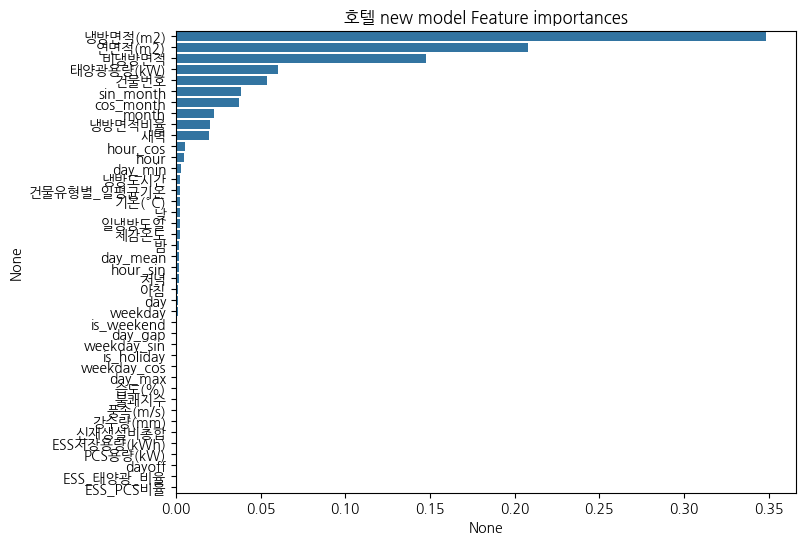

새 모델 점수 = 0.6060180304644458


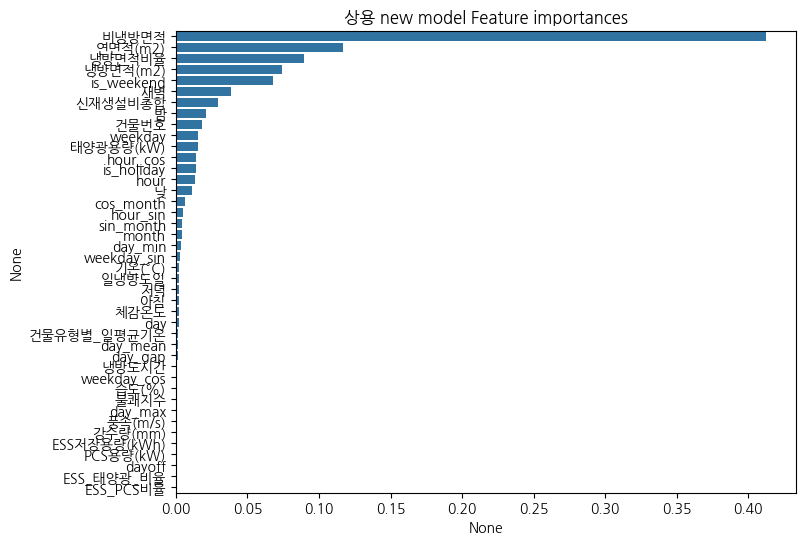

새 모델 점수 = 0.588035651177514


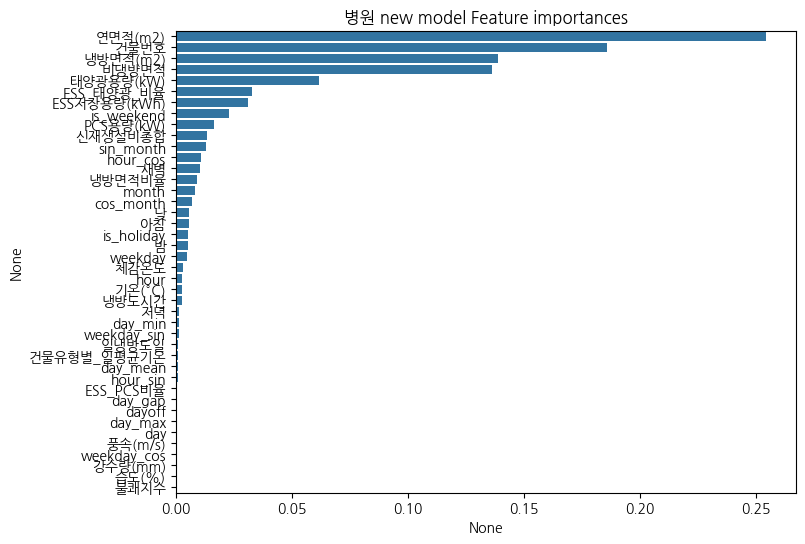

새 모델 점수 = 0.6110076323693038


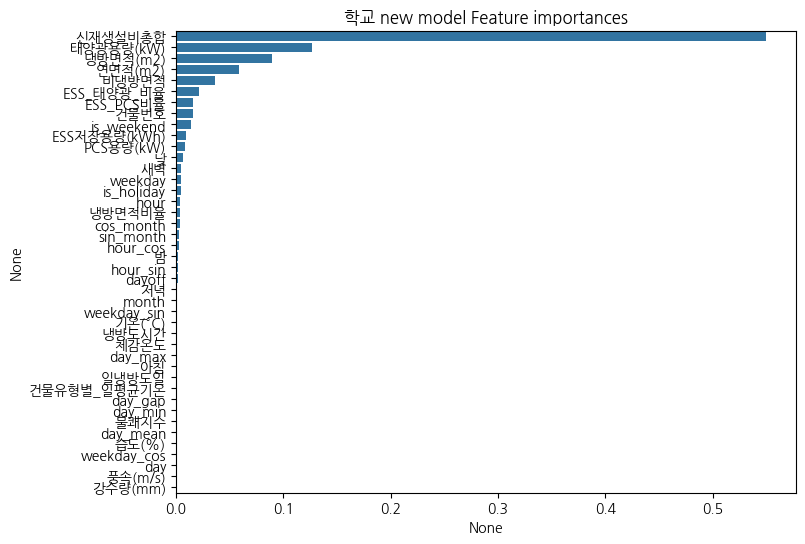

새 모델 점수 = 0.9643644048501895


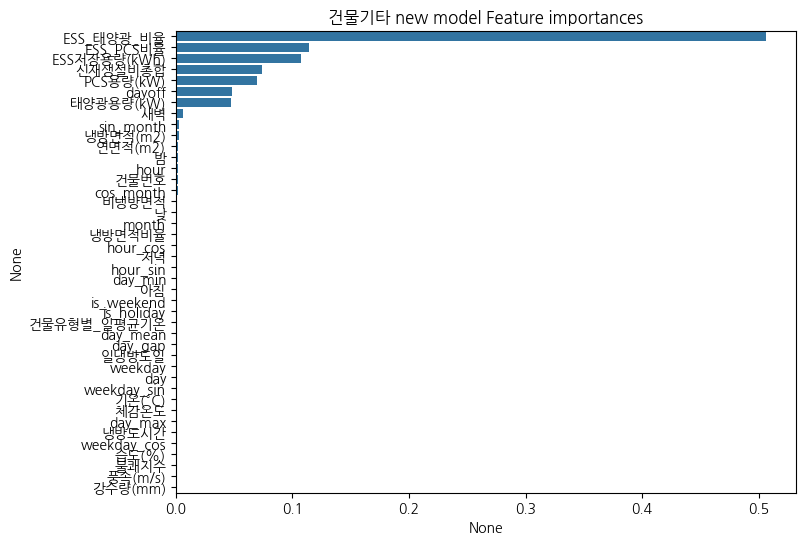

새 모델 점수 = 0.9688249179097217


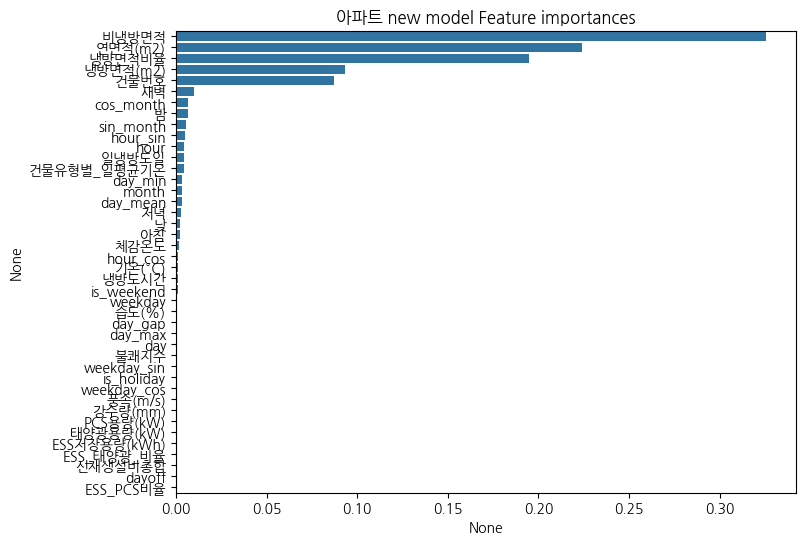

새 모델 점수 = 0.8075381105198356


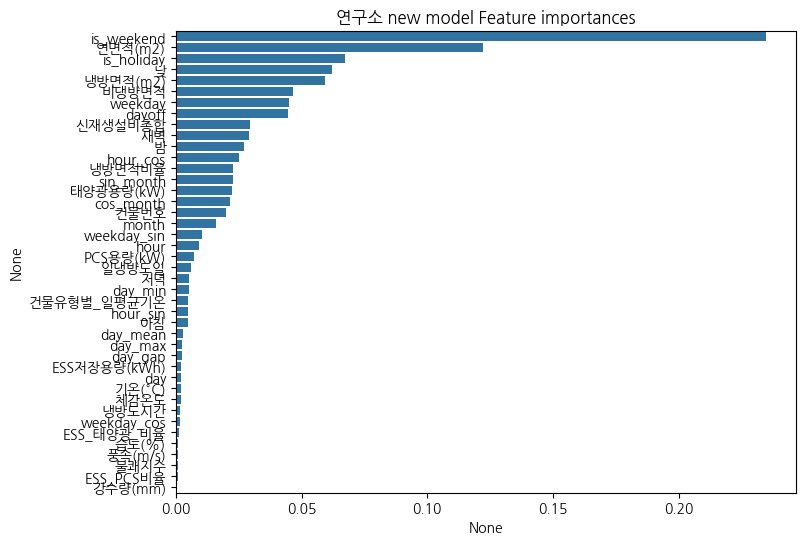

새 모델 점수 = 1.033918291576137


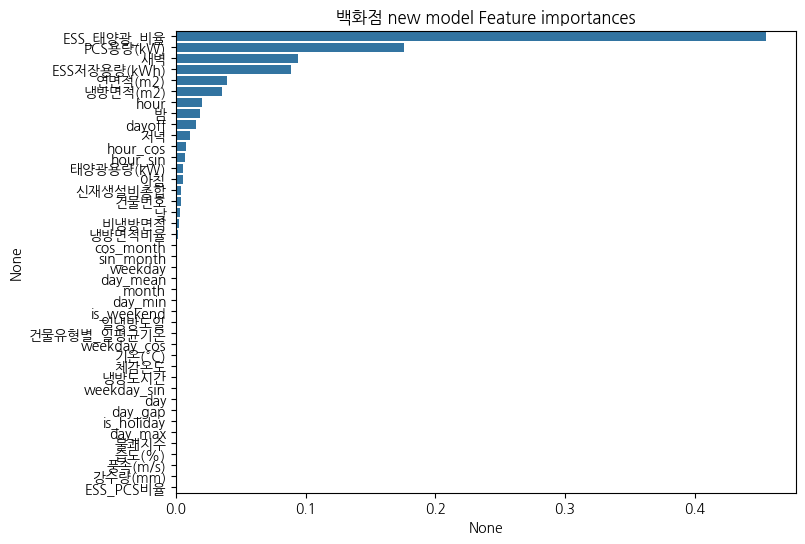

새 모델 점수 = 0.1996536604466208


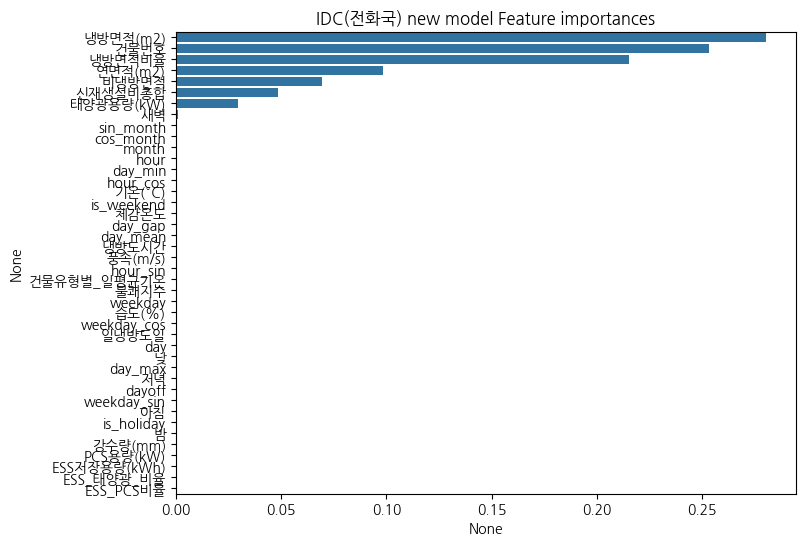

새 모델 점수 = 1.2558371877848549


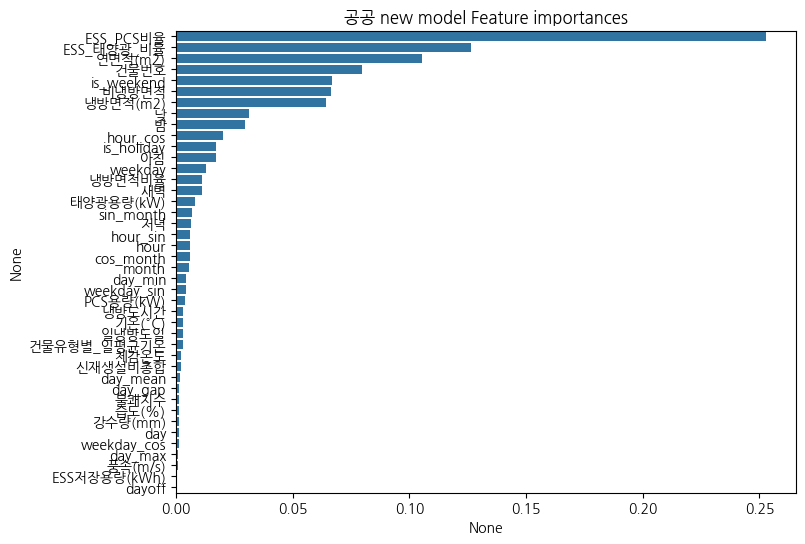

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

building_info_df = pd.read_csv('drive/MyDrive/open/building_info.csv')
train_df = pd.read_csv('drive/MyDrive/open/train.csv')
submission_df = pd.read_csv('drive/MyDrive/open/sample_submission.csv')
test_df = pd.read_csv('drive/MyDrive/open/test.csv')

X = pd.merge(train_df, building_info_df, on='건물번호', how='inner')

scaler = StandardScaler()

X['date'] = pd.to_datetime(X['일시']).dt.date
X['month'] = X['일시'].apply(lambda x : int(x[4:6]))
X['day'] = X['일시'].apply(lambda x : int(x[6:8]))
X['hour'] = X['일시'].apply(lambda x : int(x[9:11]))
X['태양광용량(kW)'] = X['태양광용량(kW)'].replace('-', 0)
X['ESS저장용량(kWh)'] = X['ESS저장용량(kWh)'].replace('-', 0)
X['PCS용량(kW)'] = X['PCS용량(kW)'].replace('-', 0)
X['태양광용량(kW)'] = X['태양광용량(kW)'].astype(float)
X['ESS저장용량(kWh)'] = X['ESS저장용량(kWh)'].astype(float)
X['PCS용량(kW)'] = X['PCS용량(kW)'].astype(float)

window = 72  # 3일(72시간) 이동 평균

# 이상치 → NaN 마스킹
for b_num, date_list in anomaly_dict.items():
    date_objs = pd.to_datetime(date_list).date
    mask = (X['건물번호'] == b_num) & (X['date'].isin(date_objs))
    X.loc[mask, '전력소비량(kWh)'] = np.nan

# NaN을 3일 이동평균으로 대체
X['전력소비량(kWh)'] = (
    X.groupby('건물번호')['전력소비량(kWh)']
     .transform(lambda s: s.fillna(s.rolling(window, min_periods=1, center=True).mean()))
)

def nearest_linear(g):
    s = g['전력소비량(kWh)'].astype(float)
    prev = s.ffill()
    nxt  = s.bfill()
    fill = (prev + nxt) / 2.0
    mask = s.isna() & prev.notna() & nxt.notna()
    g.loc[mask, '전력소비량(kWh)'] = fill[mask]
    return g

X = X.groupby('건물번호', group_keys=False).apply(nearest_linear)

y = X['전력소비량(kWh)'].values
y[y <= 0] = 1e-6
y_boxcox, fitted_lambda = boxcox(y)

X['weekday'] = pd.to_datetime(X['date']).dt.dayofweek
X['is_weekend'] = X['weekday'].apply(lambda x : 1 if x >= 5 else 0)
X['is_holiday'] = X['date'].astype(str).isin(holidays).astype(int)

X['dayoff'] = 0
for num, days in building_pred_holiday.items():
    day_list = [d.date() for d in pd.to_datetime(days)]  # Timestamp → datetime.date 변환
    X.loc[(X['건물번호'] == num) & (X['date'].isin(day_list)), 'dayoff'] = 1

# 오늘 추가
X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)
X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
X['sin_month'] = -np.sin(2 * np.pi * X['month']/12.0)
X['cos_month'] = -np.cos(2 * np.pi * X['month']/12.0)

X['비냉방면적'] = X['연면적(m2)'] - X['냉방면적(m2)']
X['신재생설비총합'] = X['ESS저장용량(kWh)'] + X['태양광용량(kW)'] + X['PCS용량(kW)']
X['ESS_태양광_비율'] = X['ESS저장용량(kWh)'] / (X['태양광용량(kW)'] + 1e-6)
X['ESS_PCS비율'] = X['ESS저장용량(kWh)'] / (X['PCS용량(kW)'] + 1e-6)
X['체감온도'] =  13.12 + 0.6215 * X['기온(°C)'] - 11.37 * X['풍속(m/s)'] ** 0.16 + 0.3965 * X['기온(°C)'] * X['풍속(m/s)'] ** 0.16
X['불쾌지수'] = 1.8 * X['기온(°C)'] - 0.55 * (1 - X['습도(%)']) * (0.18 * X['기온(°C)'] - 26) + 32
X['건물유형별_일평균기온'] = X.groupby(['건물유형', 'date'])['기온(°C)'].transform('mean')
X['일냉방도일'] = X['건물유형별_일평균기온'] - 24
X['냉방도시간'] = X['기온(°C)'] - 24

X['냉방면적비율'] = X['냉방면적(m2)'] / (X['연면적(m2)'] + 1e-6)

X['time_period'] = X['hour'].apply(get_time_period)
X = pd.get_dummies(X, columns=['time_period'], prefix='', prefix_sep='')

X['day_mean'] = X.groupby('date')['기온(°C)'].transform('mean')
X['day_min']  = X.groupby('date')['기온(°C)'].transform('min')
X['day_max']  = X.groupby('date')['기온(°C)'].transform('max')
X['day_gap']  = X['day_max'] - X['day_min']

scale_cols = ['강수량(mm)', '기온(°C)', '풍속(m/s)', '습도(%)', '냉방면적(m2)', '연면적(m2)','태양광용량(kW)',
              'ESS저장용량(kWh)', 'PCS용량(kW)', '비냉방면적', '신재생설비총합', '체감온도', '불쾌지수', '일냉방도일', '냉방도시간']

X[scale_cols] = scaler.fit_transform(X[scale_cols])

X = X.drop([
    '전력소비량(kWh)',
    '일시',
    'num_date_time',
    '일조(hr)',
    '일사(MJ/m2)',
    'date',
    ],axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size=0.2, random_state=42)
train_cols = X_train.columns

# test 저장

test_df =  pd.merge(test_df, building_info_df, on='건물번호', how='inner')
test_df['date'] = pd.to_datetime(test_df['일시']).dt.date
test_df['month'] = test_df['일시'].apply(lambda x : int(x[4:6]))
test_df['day'] = test_df['일시'].apply(lambda x : int(x[6:8]))
test_df['hour'] = test_df['일시'].apply(lambda x : int(x[9:11]))
test_df['태양광용량(kW)'] = test_df['태양광용량(kW)'].replace('-', 0)
test_df['ESS저장용량(kWh)'] = test_df['ESS저장용량(kWh)'].replace('-', 0)
test_df['PCS용량(kW)'] = test_df['PCS용량(kW)'].replace('-', 0)
test_df['태양광용량(kW)'] = test_df['태양광용량(kW)'].astype(float)
test_df['ESS저장용량(kWh)'] = test_df['ESS저장용량(kWh)'].astype(float)
test_df['PCS용량(kW)'] = test_df['PCS용량(kW)'].astype(float)

test_df['is_holiday'] = test_df['date'].astype(str).isin(holidays).astype(int)
test_df['weekday'] = pd.to_datetime(test_df['date']).dt.dayofweek
test_df['is_weekend'] = test_df['weekday'].apply(lambda x : 1 if x >= 5 else 0)

test_df['dayoff'] = 0
for num, days in building_pred_holiday.items():
    day_list = [d.date() for d in pd.to_datetime(days)]  # Timestamp → datetime.date 변환
    test_df.loc[(test_df['건물번호'] == num) & (test_df['date'].isin(day_list)), 'dayoff'] = 1

test_df['weekday_sin'] = np.sin(2 * np.pi * test_df['weekday'] / 7)
test_df['weekday_cos'] = np.cos(2 * np.pi * test_df['weekday'] / 7)
test_df['hour_sin'] = np.sin(2 * np.pi * test_df['hour'] / 24)
test_df['hour_cos'] = np.cos(2 * np.pi * test_df['hour'] / 24)
test_df['sin_month'] = -np.sin(2 * np.pi * test_df['month']/12.0)
test_df['cos_month'] = -np.cos(2 * np.pi * test_df['month']/12.0)
test_df['비냉방면적'] = test_df['연면적(m2)'] - test_df['냉방면적(m2)']
test_df['신재생설비총합'] = test_df['ESS저장용량(kWh)'] + test_df['태양광용량(kW)'] + test_df['PCS용량(kW)']
test_df['ESS_태양광_비율'] = test_df['ESS저장용량(kWh)'] / (test_df['태양광용량(kW)'] + 1e-6)
test_df['ESS_PCS비율'] = test_df['ESS저장용량(kWh)'] / (test_df['PCS용량(kW)'] + 1e-6)
test_df['체감온도'] =  13.12 + 0.6215 * test_df['기온(°C)'] - 11.37 * test_df['풍속(m/s)'] ** 0.16 + 0.3965 * test_df['기온(°C)'] * test_df['풍속(m/s)'] ** 0.16
test_df['불쾌지수'] = 1.8 * test_df['기온(°C)'] - 0.55 * (1 - test_df['습도(%)']) * (0.18 * test_df['기온(°C)'] - 26) + 32
test_df['건물유형별_일평균기온'] = test_df.groupby(['건물유형', 'date'])['기온(°C)'].transform('mean')
test_df['일냉방도일'] = test_df['건물유형별_일평균기온'] - 24
test_df['냉방도시간'] = test_df['기온(°C)'] - 24

test_df['냉방면적비율'] = test_df['냉방면적(m2)'] / (test_df['연면적(m2)'] + 1e-6)

test_df['time_period'] = test_df['hour'].apply(get_time_period)
test_df = pd.get_dummies(test_df, columns=['time_period'], prefix='', prefix_sep='')

test_df['day_mean'] = test_df.groupby('date')['기온(°C)'].transform('mean')
test_df['day_min']  = test_df.groupby('date')['기온(°C)'].transform('min')
test_df['day_max']  = test_df.groupby('date')['기온(°C)'].transform('max')
test_df['day_gap']  = test_df['day_max'] - test_df['day_min']

test_df = add_weather_rollings(test_df)

test_scale_cols = ['강수량(mm)', '기온(°C)', '풍속(m/s)', '습도(%)', '냉방면적(m2)', '연면적(m2)', '태양광용량(kW)',
                   'ESS저장용량(kWh)', 'PCS용량(kW)', '비냉방면적', '신재생설비총합', '체감온도', '불쾌지수', '일냉방도일', '냉방도시간']

test_df[test_scale_cols] = scaler.transform(test_df[test_scale_cols])

test_df = test_df.drop(['일시',
                        'date',
                        'num_date_time',
                        ], axis = 1)
test_df = test_df[train_cols]

# 1. 하이퍼파라미터

params_lst = [
    {'n_estimators': 2000, 'learning_rate': 0.018565552124493317, 'max_depth': 15, 'colsample_bytree': 0.6076495240782782, 'min_child_weight': 5, 'gamma': 0.008558875876005371, 'subsample': 0.6086893553282627, 'lambda': 3, 'alpha': 0},
    {'n_estimators': 4000, 'learning_rate': 0.05033439877484934, 'max_depth': 13, 'colsample_bytree': 0.6105793689126212, 'min_child_weight': 5, 'gamma': 0.001268250943070075, 'subsample': 0.5958875616695885, 'lambda': 2, 'alpha': 0},
    {'n_estimators': 3000, 'learning_rate': 0.024685353614575887, 'max_depth': 13, 'colsample_bytree': 0.5408248096533548, 'min_child_weight': 7, 'gamma': 0.0013089460796406893, 'subsample': 0.5752644857557982, 'lambda': 5, 'alpha': 0},
    {'n_estimators': 4000, 'learning_rate': 0.03359854714863538, 'max_depth': 11, 'colsample_bytree': 0.5897026139591793, 'min_child_weight': 11, 'gamma': 0.001009443207328403, 'subsample': 0.8544285606200173, 'lambda': 5, 'alpha': 0},
    {'n_estimators': 4000, 'learning_rate': 0.012834058857458013, 'max_depth': 12, 'colsample_bytree': 0.5840147999500054, 'min_child_weight': 5, 'gamma': 0.0012683006830282641, 'subsample': 0.8954679408268984, 'lambda': 5, 'alpha': 0},
    {'n_estimators': 4000, 'learning_rate': 0.014119739405397862, 'max_depth': 9, 'colsample_bytree': 0.5038234945116392, 'min_child_weight': 5, 'gamma': 0.00108089179432121, 'subsample': 0.6865298851890711, 'lambda': 3, 'alpha': 0},
    {'n_estimators': 3000, 'learning_rate': 0.010492848558388753, 'max_depth': 15, 'colsample_bytree': 0.6829185183797117, 'min_child_weight': 9, 'gamma': 0.001020579940605612, 'subsample': 0.8910588630968922, 'lambda': 4, 'alpha': 0},
    {'n_estimators': 3000, 'learning_rate': 0.024557736614802046, 'max_depth': 12, 'colsample_bytree': 0.6910845626159922, 'min_child_weight': 9, 'gamma': 0.006679559432889153, 'subsample': 0.8221506162574179, 'lambda': 5, 'alpha': 0},
    {'n_estimators': 3000, 'learning_rate': 0.02368492408791003, 'max_depth': 13, 'colsample_bytree': 0.638376330852491, 'min_child_weight': 5, 'gamma': 0.004029432652660231, 'subsample': 0.8119626246795447, 'lambda': 2, 'alpha': 0},
    {'n_estimators': 2000, 'learning_rate': 0.01951748828915958, 'max_depth': 12, 'colsample_bytree': 0.5796080058117432, 'min_child_weight': 5, 'gamma': 0.008928029775667975, 'subsample': 0.8425331020128781, 'lambda': 5, 'alpha': 0}
]

# 2. 건물 유형별 예측

i = 0

kinds_preds = pd.Series(index=X_test.index, dtype=float)
kinds_final_result= pd.Series(index=test_df.index, dtype=float)
type_list = X['건물유형'].unique()
for type in type_list:
  type_test = X_test[X_test['건물유형'] == type]
  type_train = X_train[X_train['건물유형'] == type]
  type_test_y = y_boxcox[type_test.index]
  type_train_y = y_boxcox[type_train.index]

  type_test = type_test.drop(['건물유형'], axis = 1)
  type_train = type_train.drop(['건물유형'], axis = 1)

  # study = optuna.create_study(direction="minimize")
  # study.optimize(make_objective(type_train, type_train_y, type_test, type_test_y), n_trials=100)
  # vis.plot_optimization_history(study)
  # vis.plot_slice(study)
  # vis.plot_parallel_coordinate(study)
  # vis.plot_param_importances(study)

  # print("xgb Best Params:", study.best_params)

  # best_params = study.best_trial.params
  best_params = params_lst[i]

  model = XGBRegressor(**best_params, random_state=42, n_jobs=-1)

  model.fit(type_train, type_train_y)
  pred6 = model.predict(type_test)

  pred = pred6
  score = smape(type_test_y, pred)
  kinds_preds.loc[type_test.index] = pred

  print(f'새 모델 점수 = {smape(type_test_y, pred6)}')

  ftr_importances_values = model.feature_importances_
  ftr_importances = pd.Series(ftr_importances_values,index=type_train.columns)
  ftr_top = ftr_importances.sort_values(ascending=False)

  plt.figure(figsize=(8,6))
  plt.title(f'{type} new model Feature importances')
  sns.barplot(x=ftr_top , y = ftr_top.index)
  plt.show()

   # test 데이터 예측
  test_df_type_idx = test_df[test_df['건물유형'] == type].index
  type_group = test_df[test_df['건물유형'] == type]
  type_group = type_group.drop(['건물유형'], axis = 1)
  final_pred = model.predict(type_group)
  kinds_final_result.loc[test_df_type_idx] = inv_boxcox(final_pred, fitted_lambda)

  i += 1


# 통합 예측 모델

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

building_info_df = pd.read_csv('drive/MyDrive/open/building_info.csv')
train_df = pd.read_csv('drive/MyDrive/open/train.csv')
submission_df = pd.read_csv('drive/MyDrive/open/sample_submission.csv')
test_df = pd.read_csv('drive/MyDrive/open/test.csv')

X = pd.merge(train_df, building_info_df, on='건물번호', how='inner')

scaler = StandardScaler()

X['date'] = pd.to_datetime(X['일시']).dt.date
X['month'] = X['일시'].apply(lambda x : int(x[4:6]))
X['day'] = X['일시'].apply(lambda x : int(x[6:8]))
X['hour'] = X['일시'].apply(lambda x : int(x[9:11]))
X['태양광용량(kW)'] = X['태양광용량(kW)'].replace('-', 0)
X['ESS저장용량(kWh)'] = X['ESS저장용량(kWh)'].replace('-', 0)
X['PCS용량(kW)'] = X['PCS용량(kW)'].replace('-', 0)
X['태양광용량(kW)'] = X['태양광용량(kW)'].astype(float)
X['ESS저장용량(kWh)'] = X['ESS저장용량(kWh)'].astype(float)
X['PCS용량(kW)'] = X['PCS용량(kW)'].astype(float)

window = 72  # 3일(72시간) 이동 평균

# 이상치 → NaN 마스킹
for b_num, date_list in anomaly_dict.items():
    date_objs = pd.to_datetime(date_list).date
    mask = (X['건물번호'] == b_num) & (X['date'].isin(date_objs))
    X.loc[mask, '전력소비량(kWh)'] = np.nan

# NaN을 3일 이동평균으로 대체
X['전력소비량(kWh)'] = (
    X.groupby('건물번호')['전력소비량(kWh)']
     .transform(lambda s: s.fillna(s.rolling(window, min_periods=1, center=True).mean()))
)

def nearest_linear(g):
    s = g['전력소비량(kWh)'].astype(float)
    prev = s.ffill()
    nxt  = s.bfill()
    fill = (prev + nxt) / 2.0
    mask = s.isna() & prev.notna() & nxt.notna()
    g.loc[mask, '전력소비량(kWh)'] = fill[mask]
    return g

X = X.groupby('건물번호', group_keys=False).apply(nearest_linear)

y = X['전력소비량(kWh)'].values
y[y <= 0] = 1e-6
y_boxcox, fitted_lambda = boxcox(y)

X['weekday'] = pd.to_datetime(X['date']).dt.dayofweek
X['is_weekend'] = X['weekday'].apply(lambda x : 1 if x >= 5 else 0)
X['is_holiday'] = X['date'].astype(str).isin(holidays).astype(int)

X['dayoff'] = 0
for num, days in building_pred_holiday.items():
    day_list = [d.date() for d in pd.to_datetime(days)]  # Timestamp → datetime.date 변환
    X.loc[(X['건물번호'] == num) & (X['date'].isin(day_list)), 'dayoff'] = 1

X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)
X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
X['sin_month'] = -np.sin(2 * np.pi * X['month']/12.0)
X['cos_month'] = -np.cos(2 * np.pi * X['month']/12.0)

X = pd.get_dummies(X, columns=['건물유형'], prefix='', prefix_sep='')
X['비냉방면적'] = X['연면적(m2)'] - X['냉방면적(m2)']
X['신재생설비총합'] = X['ESS저장용량(kWh)'] + X['태양광용량(kW)'] + X['PCS용량(kW)']
X['ESS_태양광_비율'] = X['ESS저장용량(kWh)'] / (X['태양광용량(kW)'] + 1e-6)
X['ESS_PCS비율'] = X['ESS저장용량(kWh)'] / (X['PCS용량(kW)'] + 1e-6)
X['체감온도'] =  13.12 + 0.6215 * X['기온(°C)'] - 11.37 * X['풍속(m/s)'] ** 0.16 + 0.3965 * X['기온(°C)'] * X['풍속(m/s)'] ** 0.16
X['불쾌지수'] = 1.8 * X['기온(°C)'] - 0.55 * (1 - X['습도(%)']) * (0.18 * X['기온(°C)'] - 26) + 32
X['건물번호별_일평균기온'] = X.groupby(['건물번호', 'date'])['기온(°C)'].transform('mean')
X['일냉방도일'] = X['건물번호별_일평균기온'] - 24
X['냉방도시간'] = X['기온(°C)'] - 24

X['time_period'] = X['hour'].apply(get_time_period)
X = pd.get_dummies(X, columns=['time_period'], prefix='', prefix_sep='')

X['day_mean'] = X.groupby('date')['기온(°C)'].transform('mean')
X['day_min']  = X.groupby('date')['기온(°C)'].transform('min')
X['day_max']  = X.groupby('date')['기온(°C)'].transform('max')
X['day_gap']  = X['day_max'] - X['day_min']

scale_cols = ['강수량(mm)', '기온(°C)', '풍속(m/s)', '습도(%)', '냉방면적(m2)', '연면적(m2)','태양광용량(kW)',
              'ESS저장용량(kWh)', 'PCS용량(kW)', '비냉방면적', '신재생설비총합', '체감온도', '불쾌지수', '일냉방도일', '냉방도시간']

X[scale_cols] = scaler.fit_transform(X[scale_cols])

X = X.drop([
    '전력소비량(kWh)',
    '일시',
    'num_date_time',
    '일조(hr)',
    '일사(MJ/m2)',
    'date',
    ],axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size=0.2, random_state=42)
train_cols = X_train.columns

# test 저장
test_df =  pd.merge(test_df, building_info_df, on='건물번호', how='inner')
test_df['date'] = pd.to_datetime(test_df['일시']).dt.date
test_df['month'] = test_df['일시'].apply(lambda x : int(x[4:6]))
test_df['day'] = test_df['일시'].apply(lambda x : int(x[6:8]))
test_df['hour'] = test_df['일시'].apply(lambda x : int(x[9:11]))
test_df['태양광용량(kW)'] = test_df['태양광용량(kW)'].replace('-', 0)
test_df['ESS저장용량(kWh)'] = test_df['ESS저장용량(kWh)'].replace('-', 0)
test_df['PCS용량(kW)'] = test_df['PCS용량(kW)'].replace('-', 0)
test_df['태양광용량(kW)'] = test_df['태양광용량(kW)'].astype(float)
test_df['ESS저장용량(kWh)'] = test_df['ESS저장용량(kWh)'].astype(float)
test_df['PCS용량(kW)'] = test_df['PCS용량(kW)'].astype(float)

test_df['is_holiday'] = test_df['date'].astype(str).isin(holidays).astype(int)
test_df['weekday'] = pd.to_datetime(test_df['date']).dt.dayofweek
test_df['is_weekend'] = test_df['weekday'].apply(lambda x : 1 if x >= 5 else 0)

test_df['dayoff'] = 0
for num, days in building_pred_holiday.items():
    day_list = [d.date() for d in pd.to_datetime(days)]  # Timestamp → datetime.date 변환
    test_df.loc[(test_df['건물번호'] == num) & (test_df['date'].isin(day_list)), 'dayoff'] = 1


test_df = pd.get_dummies(test_df, columns=['건물유형'], prefix='', prefix_sep='')
test_df['weekday_sin'] = np.sin(2 * np.pi * test_df['weekday'] / 7)
test_df['weekday_cos'] = np.cos(2 * np.pi * test_df['weekday'] / 7)
test_df['hour_sin'] = np.sin(2 * np.pi * test_df['hour'] / 24)
test_df['hour_cos'] = np.cos(2 * np.pi * test_df['hour'] / 24)
test_df['sin_month'] = -np.sin(2 * np.pi * test_df['month']/12.0)
test_df['cos_month'] = -np.cos(2 * np.pi * test_df['month']/12.0)
test_df['비냉방면적'] = test_df['연면적(m2)'] - test_df['냉방면적(m2)']
test_df['신재생설비총합'] = test_df['ESS저장용량(kWh)'] + test_df['태양광용량(kW)'] + test_df['PCS용량(kW)']
test_df['ESS_태양광_비율'] = test_df['ESS저장용량(kWh)'] / (test_df['태양광용량(kW)'] + 1e-6)
test_df['ESS_PCS비율'] = test_df['ESS저장용량(kWh)'] / (test_df['PCS용량(kW)'] + 1e-6)
test_df['체감온도'] =  13.12 + 0.6215 * test_df['기온(°C)'] - 11.37 * test_df['풍속(m/s)'] ** 0.16 + 0.3965 * test_df['기온(°C)'] * test_df['풍속(m/s)'] ** 0.16
test_df['불쾌지수'] = 1.8 * test_df['기온(°C)'] - 0.55 * (1 - test_df['습도(%)']) * (0.18 * test_df['기온(°C)'] - 26) + 32
test_df['건물번호별_일평균기온'] = test_df.groupby(['건물번호', 'date'])['기온(°C)'].transform('mean')
test_df['일냉방도일'] = test_df['건물번호별_일평균기온'] - 24
test_df['냉방도시간'] = test_df['기온(°C)'] - 24

test_df['time_period'] = test_df['hour'].apply(get_time_period)
test_df = pd.get_dummies(test_df, columns=['time_period'], prefix='', prefix_sep='')

test_df['day_mean'] = test_df.groupby('date')['기온(°C)'].transform('mean')
test_df['day_min']  = test_df.groupby('date')['기온(°C)'].transform('min')
test_df['day_max']  = test_df.groupby('date')['기온(°C)'].transform('max')
test_df['day_gap']  = test_df['day_max'] - test_df['day_min']

test_df = add_weather_rollings(test_df)

test_scale_cols = ['강수량(mm)', '기온(°C)', '풍속(m/s)', '습도(%)', '냉방면적(m2)', '연면적(m2)', '태양광용량(kW)',
                   'ESS저장용량(kWh)', 'PCS용량(kW)', '비냉방면적', '신재생설비총합', '체감온도', '불쾌지수', '일냉방도일', '냉방도시간']
test_df[test_scale_cols] = scaler.transform(test_df[test_scale_cols])

test_df = test_df.drop(['일시',
                        'date',
                        'num_date_time',
                        ], axis = 1)
test_df = test_df[train_cols]

# 통합 예측

# study = optuna.create_study(direction="minimize")
# study.optimize(make_objective(X_train, y_train, X_test, y_test), n_trials=100)
# vis.plot_optimization_history(study)
# vis.plot_slice(study)
# vis.plot_parallel_coordinate(study)
# vis.plot_param_importances(study)

# print("xgb Best Params:", study.best_params)

# best_params = study.best_trial.params

best_params = {'n_estimators': 2000, 'learning_rate': 0.025179795565696206, 'max_depth': 15, 'colsample_bytree': 0.60295751163085, 'min_child_weight': 5, 'gamma': 0.008164610367138506, 'subsample': 0.7107605374876664, 'lambda': 2, 'alpha': 0}

model = XGBRegressor(**best_params, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

model_result = model.predict(X_test)
model_final = inv_boxcox(model.predict(test_df), fitted_lambda)

final_result = (model_final + kinds_final_result.values) / 2
final_result = model_final

result = (model_result + kinds_preds.values) / 2
score = smape(y_test, result)

print(f'새로운 모델 점수 = {smape(y_test, model_result)}')
print(f'앙상블 모델 점수 = {score}')

test_df['전력소비량(kWh)'] = final_result
submission_df['answer'] = final_result


/tmp/ipython-input-3183613971.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X = X.groupby('건물번호', group_keys=False).apply(nearest_linear)


새로운 모델 점수 = 0.8275506397654644
앙상블 모델 점수 = 0.7991272082242823


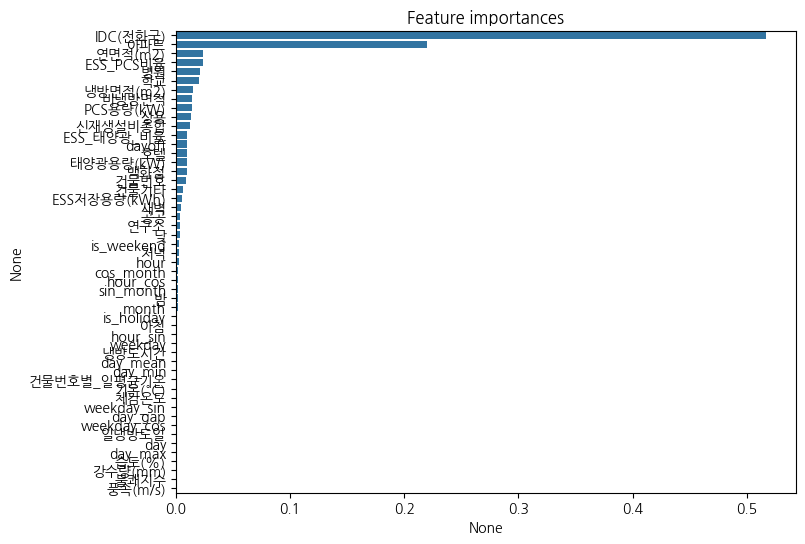

In [7]:
ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x=ftr_top , y = ftr_top.index)
plt.show()

In [11]:
import sys
import matplotlib
import sktime
import sklearn
import xgboost
print("-------------------------- Python & library version --------------------------")
print("개발환경 : Windows colab")
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("sktime version: {}".format(sktime.__version__))
print("sklearn version: {}".format(sklearn.__version__))
print("xgboost version: {}".format(xgboost.__version__))
print("------------------------------------------------------------------------------")

-------------------------- Python & library version --------------------------
개발환경 : Windows colab
Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
pandas version: 2.2.2
numpy version: 2.0.2
matplotlib version: 3.10.0
sktime version: 0.38.5
sklearn version: 1.6.1
xgboost version: 3.0.4
------------------------------------------------------------------------------
